# Time series Analysis with ARIMA models

In [2]:
library(fpp2)
library(readxl) 
library(tidyverse)
library(forecast)
library(urca)

In [3]:
#read data to R and plot 
myts <- read_xlsx("RetailData.xlsx", skip=3) %>% pull("28397371") %>% 
  ts(start = c(1982,4), frequency = 12)

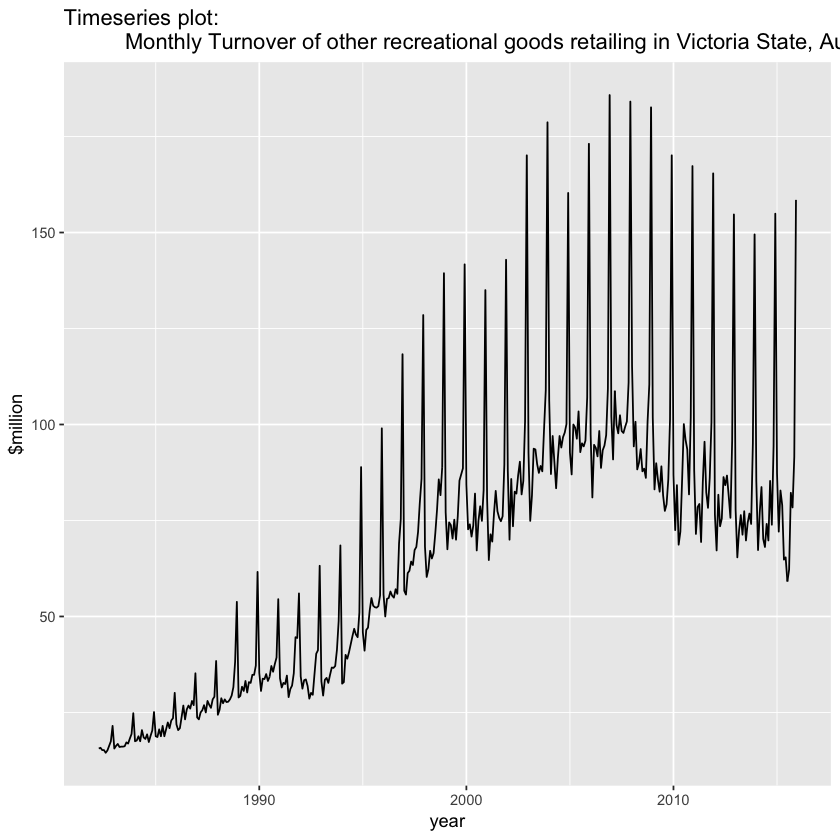

In [4]:
#plot original data
autoplot(myts)+ 
  ggtitle("Timeseries plot:
          Monthly Turnover of other recreational goods retailing in Victoria State, Australia")+
  xlab("year")+ 
  ylab("$million") 

### Q1 To achieve stationarity

* The data show increasing variation as the level of the series increases, a transformation can be useful to stabilise the variance.
* Use BoxCox selecting best lambda value and to do the data transformation.

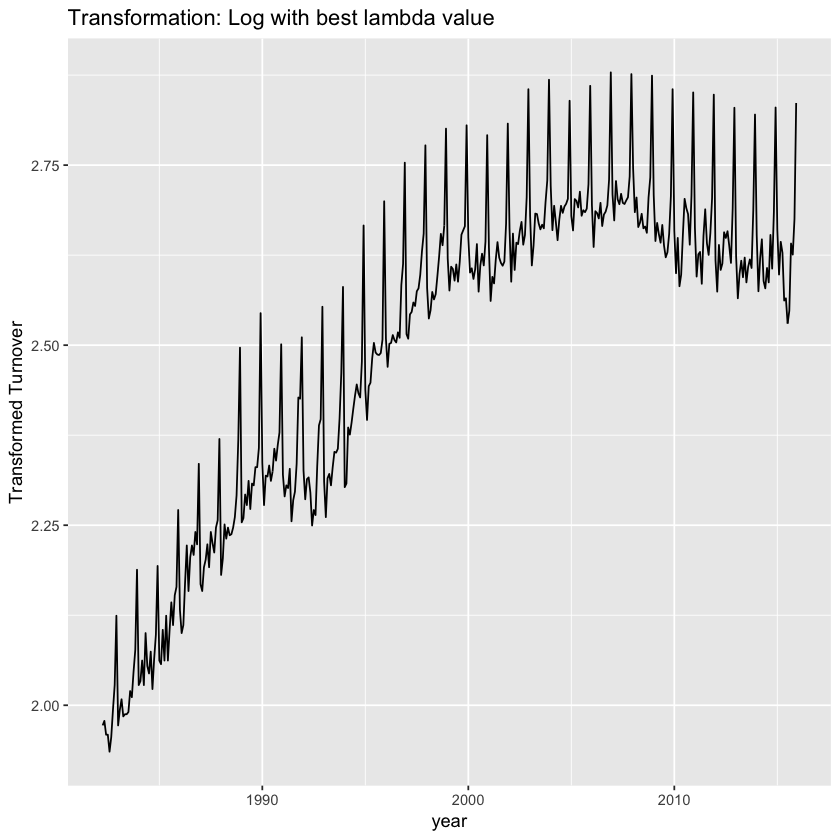

In [5]:
#plot for transformed data to stabilise the variance of the data
autoplot(BoxCox(myts,lambda = BoxCox.lambda(myts)))+
  ggtitle("Transformation: Log with best lambda value ")+
  xlab("year")+
  ylab("Transformed Turnover") 

*  The transformed data now has stable variations.

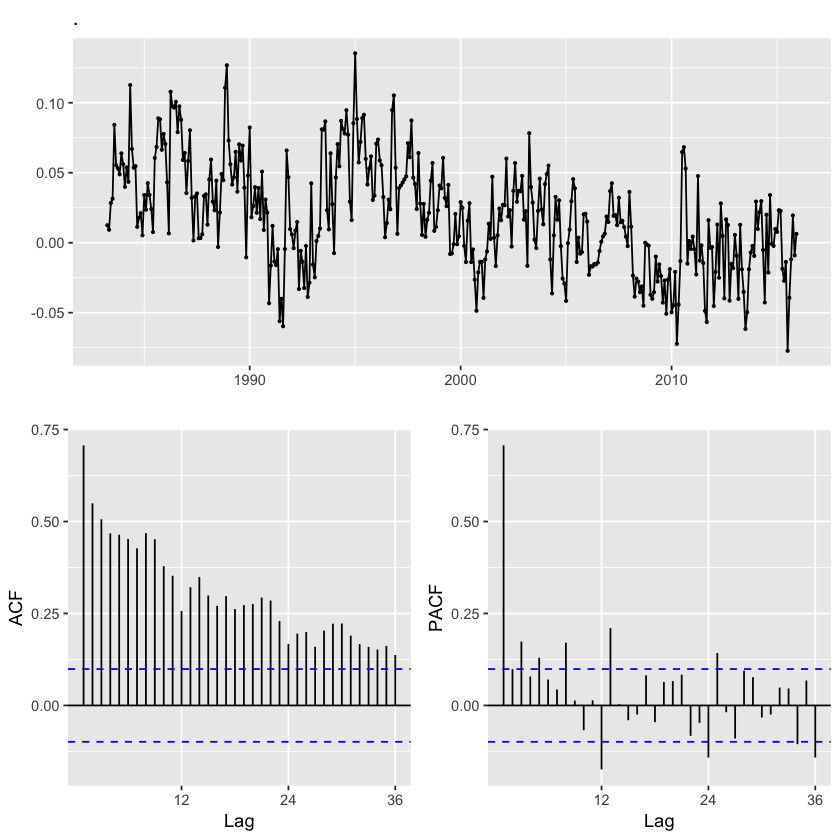

In [7]:
# The transformed data has strong seasonality as December values are much larger than rest of months. Take one-time seasonal differencing to eliminate seasonality.
# From the ACF plot, however, lags decrease slowly showing a trend need to be removed.
#transformed data + one time seasonal differencing 
myts %>% BoxCox(BoxCox.lambda(myts)) %>% diff(lag=12)  %>% ggtsdisplay()

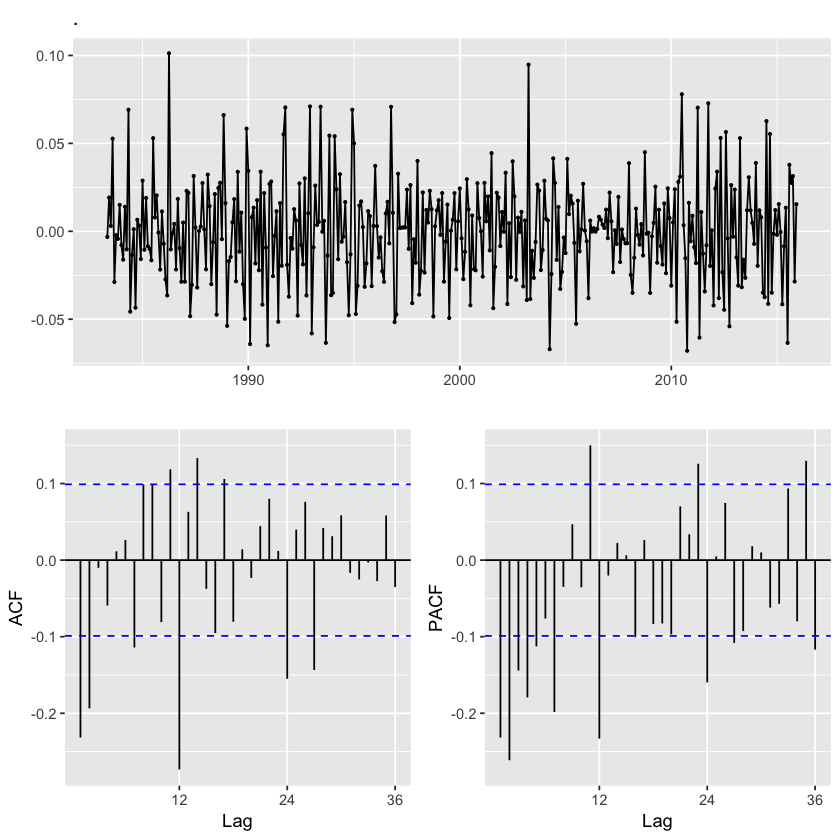

In [8]:
# Add a first order differencing plus seasonal differencing to the transformed data. 
# The time plot with ACF and PACF showing that the data now is stationary 
# as 1. variation stabilised (not change with level) 2. no trend (roughly horizontal for the series) 3.no seasonality.

#transformed data + one time seasonal differencing + first order differencing
myts %>% BoxCox(BoxCox.lambda(myts)) %>% diff(lag=12)%>% diff  %>% ggtsdisplay()

In [9]:
# Run KPSS test to confirm the stationary. 
# Test-statistic is 0.0144 which is much lower than the 1% critical value 
# indicating that cannot reject the null hypothesis that the data are stationary.
#Run KPSS test to confirmed it is stationary
myts %>% BoxCox(BoxCox.lambda(myts)) %>% diff(lag=12) %>% diff %>% ur.kpss %>% summary()


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0144 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


### Q2 Plot the ACF and PACF of the stationary data. Reading from these choose an appropriate ARIMA model.


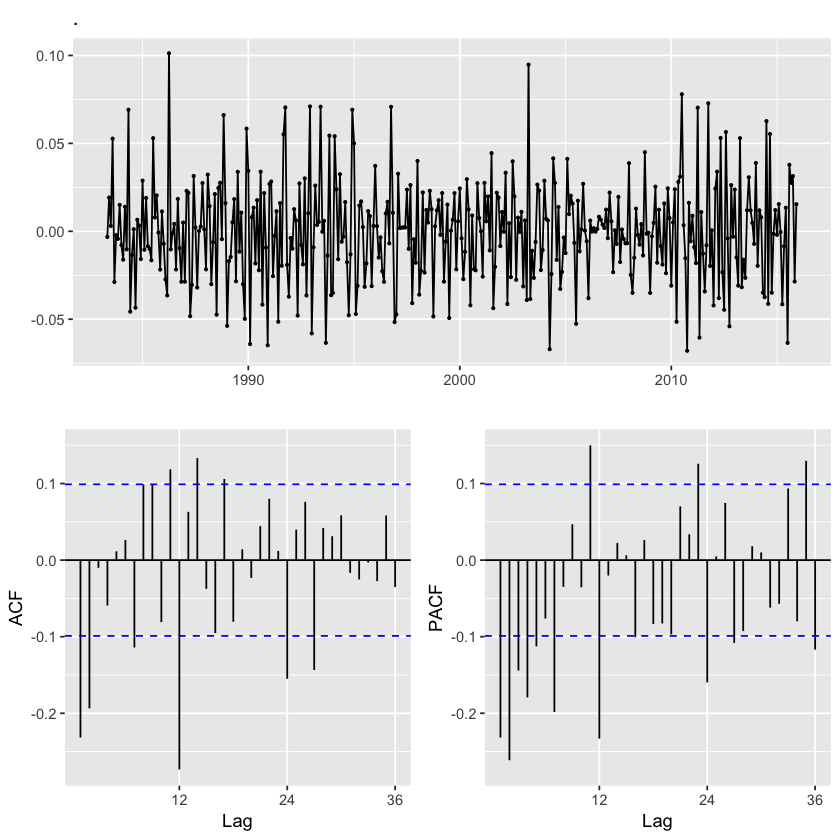

In [10]:
#Plot the ACF and PACF of the stationary data
myts %>% BoxCox(BoxCox.lambda(myts)) %>% diff(lag=12)%>% diff  %>% ggtsdisplay()


In [11]:
# ACF looks clear than the messy PACF. Hence, identifying model from ACF,  
# I picked q = 2 as the second longest significant lag fall on lag 2
# (not considered the longest one which is lag 7 to make a model simpler)
# and picked Q = 2 for the longest significant seasonal lag at lag 24.
# With the chosen differencing d= 1 and D=1 together, I selected model 
# ARIMA(0,1,2)(0,1,2)[12].
#pick model from ACF
Arima(myts, lambda = BoxCox.lambda(myts), order = c(0,1,2), seasonal = c(0,1,2))

Series: myts 
ARIMA(0,1,2)(0,1,2)[12] 
Box Cox transformation: lambda= -0.2563538 

Coefficients:
          ma1      ma2     sma1     sma2
      -0.3963  -0.3104  -0.4904  -0.2587
s.e.   0.0477   0.0473   0.0503   0.0493

sigma^2 estimated as 0.0005324:  log likelihood=918.7
AIC=-1827.41   AICc=-1827.25   BIC=-1807.55

### Q3 Check the whiteness of the residuals from the fitted ARIMA model. 


	Ljung-Box test

data:  Residuals from ARIMA(0,1,2)(0,1,2)[12]
Q* = 32.088, df = 20, p-value = 0.04237

Model df: 4.   Total lags used: 24



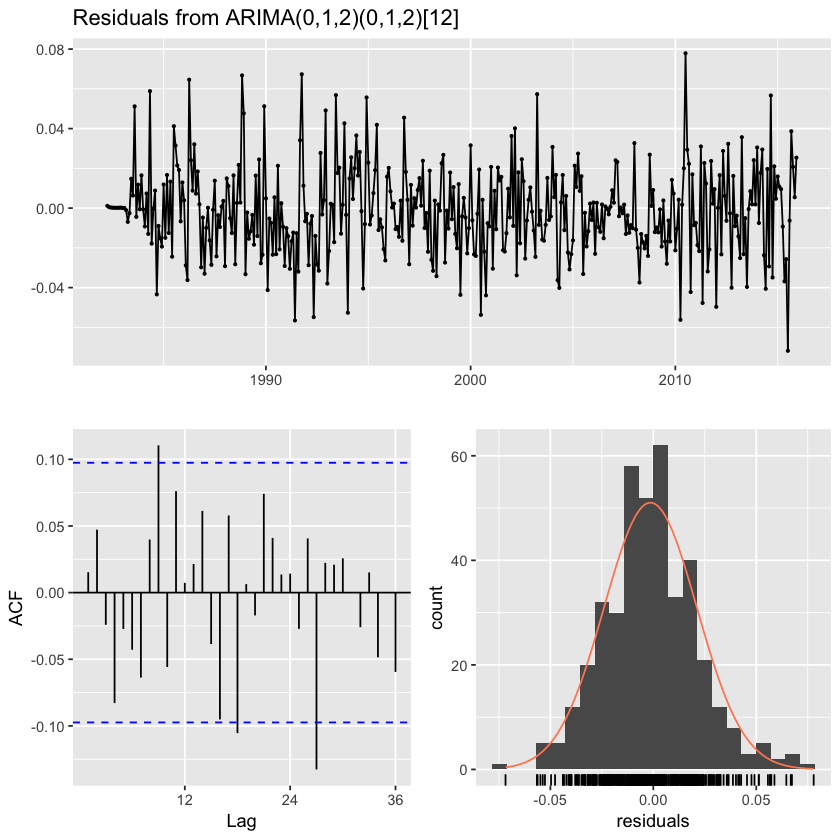

In [12]:
#plot residuals from the fitted AIRMA model
Arima(myts, lambda = BoxCox.lambda(myts), order = c(0,1,2), seasonal = c(0,1,2)) %>% checkresiduals() 

# The mean of residuals is close to zero and distribution is close to standard
# normal. However, variation of the residuals is not much consistent across 
# the data. The two significant lags in first 24 lags with p-value 0.04237 
# smaller than 0.05 rejected the null hypothesis for the white noise. 
# Residuals are not a white noise but very close to it, indicating little 
# information left uncaptured by the fitted ARIMA model.

### Q4 Consider three to five alternative ARIMA models based on your choice in Q2 and Q3. Use information criteria to choose the best model you have considered so far.

In [13]:
# ARIMA(5,1,0)(3,1,0)[12]: Model picked from the messy PACF. 
# Picked p = 5 as within the first 6 lags the longest significant
# is lag 5 and P = 3 as the longest significant seasonal lag at lags 36. 
Arima(myts, lambda = BoxCox.lambda(myts), order = c(5,1,0), seasonal = c(3,1,0))

Series: myts 
ARIMA(5,1,0)(3,1,0)[12] 
Box Cox transformation: lambda= -0.2563538 

Coefficients:
          ar1      ar2      ar3      ar4      ar5     sar1     sar2     sar3
      -0.3408  -0.3561  -0.2139  -0.2232  -0.1046  -0.3838  -0.3194  -0.2201
s.e.   0.0508   0.0523   0.0546   0.0529   0.0512   0.0513   0.0530   0.0530

sigma^2 estimated as 0.0005903:  log likelihood=902.82
AIC=-1787.64   AICc=-1787.17   BIC=-1751.9

In [14]:
# ARIMA(5,1,0)(2,1,0)[12] :A simpler model that reduce the order of P 
# from 3 to 2.
Arima(myts, lambda = BoxCox.lambda(myts), order = c(5,1,0), seasonal = c(2,1,0))

Series: myts 
ARIMA(5,1,0)(2,1,0)[12] 
Box Cox transformation: lambda= -0.2563538 

Coefficients:
          ar1      ar2      ar3      ar4      ar5     sar1     sar2
      -0.3418  -0.3553  -0.2219  -0.2195  -0.1018  -0.3245  -0.2430
s.e.   0.0509   0.0523   0.0546   0.0529   0.0511   0.0505   0.0509

sigma^2 estimated as 0.0006173:  log likelihood=894.47
AIC=-1772.95   AICc=-1772.57   BIC=-1741.18

In [15]:
#ARIMA(4,1,0)(3,1,0)[12] : A simpler model that reduce the order of p from 5 to 4.
Arima(myts, lambda = BoxCox.lambda(myts), order = c(4,1,0), seasonal = c(3,1,0))

Series: myts 
ARIMA(4,1,0)(3,1,0)[12] 
Box Cox transformation: lambda= -0.2563538 

Coefficients:
          ar1      ar2      ar3      ar4     sar1     sar2     sar3
      -0.3200  -0.3360  -0.1774  -0.1878  -0.3901  -0.3226  -0.2185
s.e.   0.0501   0.0516   0.0518   0.0502   0.0513   0.0531   0.0529

sigma^2 estimated as 0.000595:  log likelihood=900.75
AIC=-1785.5   AICc=-1785.12   BIC=-1753.73

In [16]:
#ARIMA(2,1,2)(2,1,2)[12] : increase p and P from the fitted model chosen from ACF plot from 0 to 2.
Arima(myts, lambda = BoxCox.lambda(myts), order = c(2,1,2), seasonal = c(2,1,2))

Series: myts 
ARIMA(2,1,2)(2,1,2)[12] 
Box Cox transformation: lambda= -0.2563538 

Coefficients:
          ar1     ar2     ma1      ma2    sar1     sar2     sma1    sma2
      -0.4687  0.3493  0.0794  -0.7817  0.7417  -0.2764  -1.2020  0.3553
s.e.   0.0903  0.0772  0.0687   0.0653  0.2787   0.1287   0.2793  0.2468

sigma^2 estimated as 0.0005294:  log likelihood=921.75
AIC=-1825.5   AICc=-1825.03   BIC=-1789.76

In [17]:
#ARIMA(2,1,2)(1,1,2)[12]: Try a slightly simpler combination from the previous model by reducing order of P from 2 to 1.
Arima(myts, lambda = BoxCox.lambda(myts), order = c(2,1,2), seasonal = c(1,1,2))

Series: myts 
ARIMA(2,1,2)(1,1,2)[12] 
Box Cox transformation: lambda= -0.2563538 

Coefficients:
          ar1     ar2     ma1      ma2    sar1     sma1     sma2
      -0.4773  0.3472  0.0888  -0.7851  0.1571  -0.6181  -0.1778
s.e.   0.0852  0.0753  0.0625   0.0602  0.1787   0.1760   0.1211

sigma^2 estimated as 0.0005299:  log likelihood=920.94
AIC=-1825.88   AICc=-1825.5   BIC=-1794.11

##### All models are at the same base that has same transformation, d=1 and D=1 that we can directly compare the AICc to choose the best one. 

##### The fitted model ARIMA(0,1,2)(0,1,2)[12] that I selected in Question 2 is the best as it has the smallest AICc = -1827.25.


### Q5 Use auto.arima to choose a model. Perform residual diagnostics analysis for this model. 

Series: myts 
ARIMA(2,1,1)(0,1,2)[12] 
Box Cox transformation: lambda= -0.2563538 

Coefficients:
         ar1      ar2      ma1     sma1     sma2
      0.4375  -0.0885  -0.8204  -0.4836  -0.2633
s.e.  0.0647   0.0564   0.0432   0.0506   0.0493

sigma^2 estimated as 0.0005316:  log likelihood=919.5
AIC=-1827   AICc=-1826.79   BIC=-1803.18


	Ljung-Box test

data:  Residuals from ARIMA(2,1,1)(0,1,2)[12]
Q* = 30.338, df = 19, p-value = 0.04766

Model df: 5.   Total lags used: 24



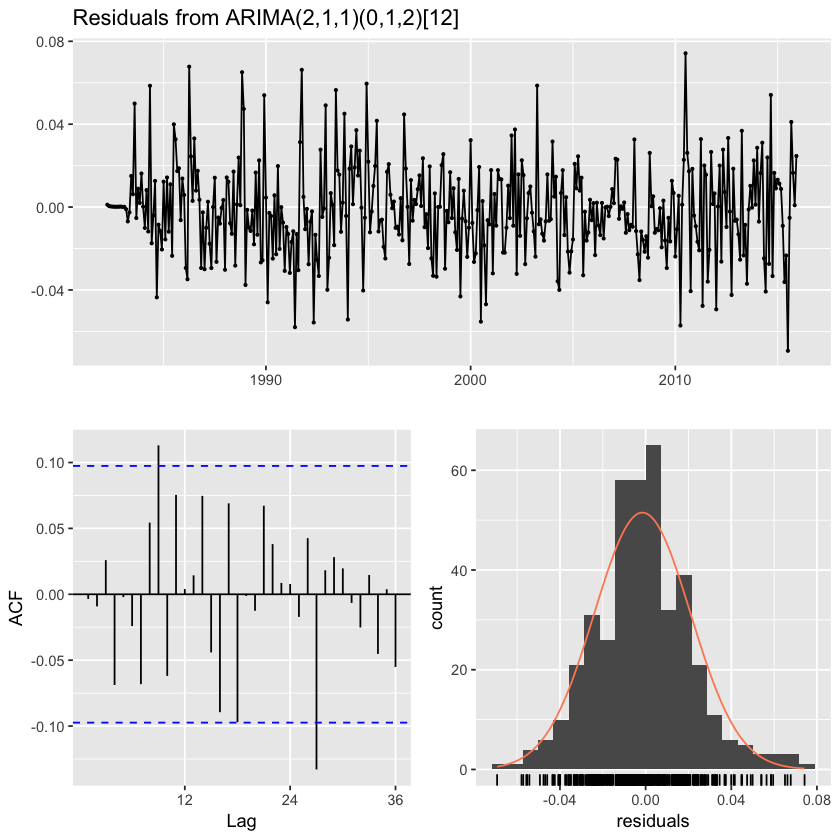

In [18]:
#model select by auto.arima function with default setting
auto.arima(myts,lambda = BoxCox.lambda(myts))
auto.arima(myts,lambda = BoxCox.lambda(myts)) %>% checkresiduals() 

* Residual of the auto-selected model ARIMA(2,1,1)(0,1,2)[12] look similar to my chosen model ARIMA(0,1,2)(0,1,2)[12]. 
* The only difference is that it has only one significant lag in first 24 lags with p-value 0.04766 that closer to 0.5 indicating the it is closer to the white noise. However, a little bit larger 
* AICc = -1826.79 showing that my chosen model is more fitted to the given time series. 

### Q6 Use again auto.arima but this time set stepwise=FALSE and approximation=FALSE.

Series: myts 
ARIMA(0,1,2)(0,1,2)[12] 
Box Cox transformation: lambda= -0.2563538 

Coefficients:
          ma1      ma2     sma1     sma2
      -0.3963  -0.3104  -0.4904  -0.2587
s.e.   0.0477   0.0473   0.0503   0.0493

sigma^2 estimated as 0.0005324:  log likelihood=918.7
AIC=-1827.41   AICc=-1827.25   BIC=-1807.55


	Ljung-Box test

data:  Residuals from ARIMA(0,1,2)(0,1,2)[12]
Q* = 32.088, df = 20, p-value = 0.04237

Model df: 4.   Total lags used: 24



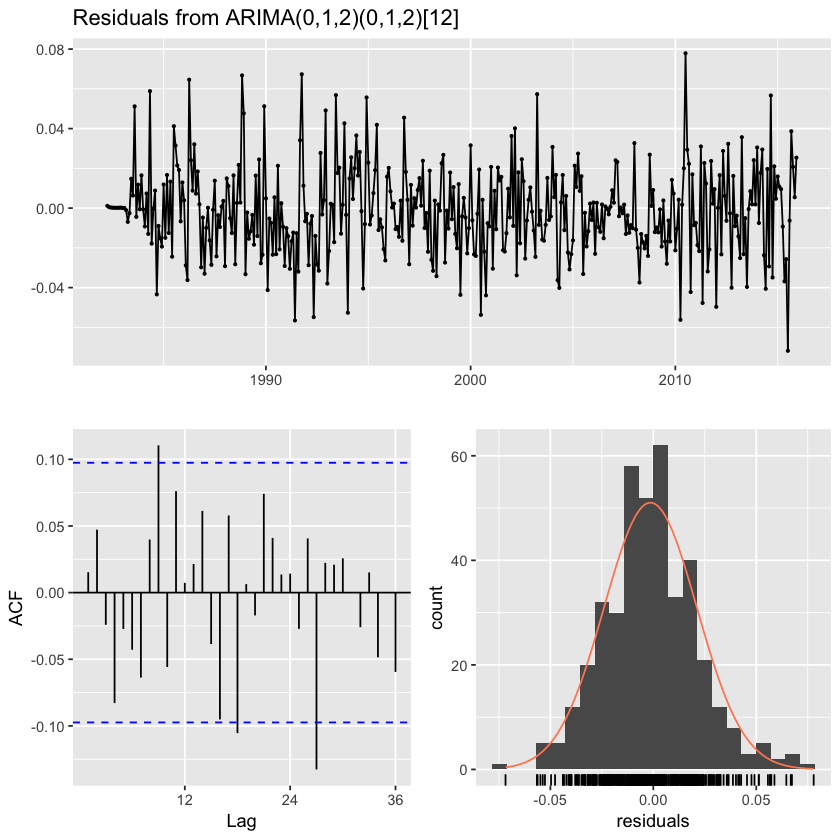

In [20]:
#run auto.arima with stepwise = F, approximation=F
auto.arima(myts,lambda = BoxCox.lambda(myts), stepwise = F, approximation=F)
auto.arima(myts,lambda = BoxCox.lambda(myts), stepwise = F, approximation=F) %>% checkresiduals()
# It returned a different model from question 5, as the setting let function 
# search all combination to get the best model. The selected model 
# ARIMA(0,1,2)(0,1,2)[12] is the same one as the best model I chose 
# in previous questions. The residual is very close to white noise 
# (see question 3).

### Q7 If needed use an appropriate test set to choose the ARIMA model you want to use for forecasting. Which model have you selected and why?


* There is no need to use test set for choosing ARIMA model in this case as both manually and automated selected models are in the same base with d=1 and D=1 that we can directly selected model by comparing the AICc. 
* ARIMA(0,1,2)(0,1,2)[12], with lowest AICc = -1827.25, is the most appropriated one for forecasting.


### Q8 Generate and plot forecasts and forecast intervals from the chosen model for the period 2016-2017.

Series: myts 
ARIMA(0,1,2)(0,1,2)[12] 
Box Cox transformation: lambda= -0.2563538 

Coefficients:
          ma1      ma2     sma1     sma2
      -0.3963  -0.3104  -0.4904  -0.2587
s.e.   0.0477   0.0473   0.0503   0.0493

sigma^2 estimated as 0.0005324:  log likelihood=918.7
AIC=-1827.41   AICc=-1827.25   BIC=-1807.55

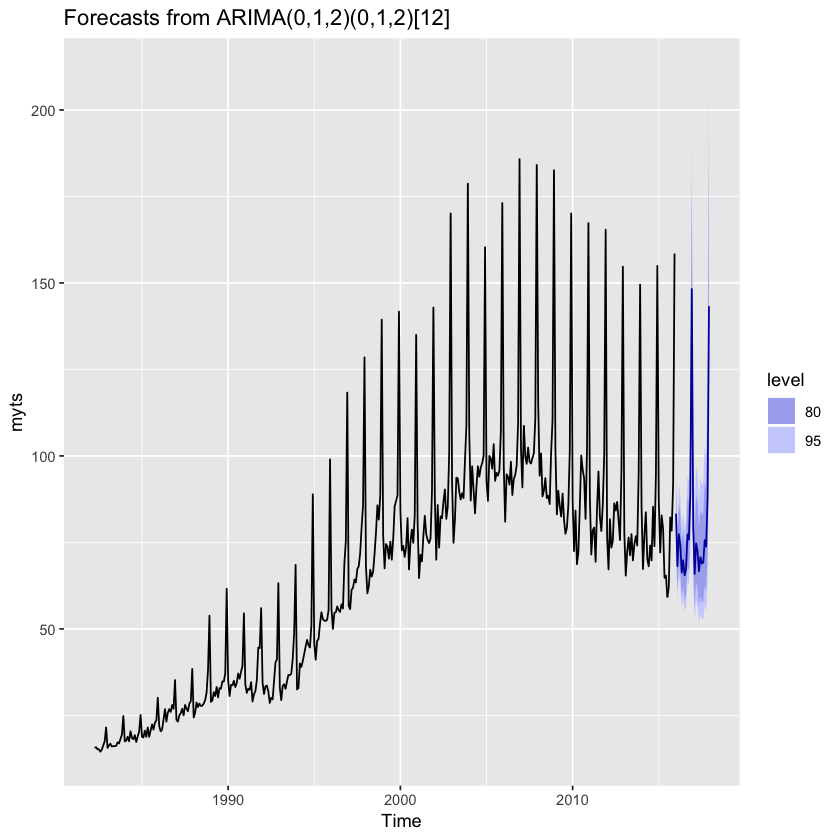

In [21]:
#fit model
fit_arima <- Arima(myts, lambda = BoxCox.lambda(myts), order = c(0,1,2), seasonal = c(0,1,2))
#do forecasting for 2016-2017
fore_arima <- fit_arima %>% forecast(h=12*2)
fore_arima  %>% autoplot()
fit_arima

# In the forecasts, it shows seasonality but no trend and the seasonal 
# variations decrease by year. 
# In addition, wide prediction interval in second year forecasting indicates uncertainty for 
# the prediction.


### Q9 Evaluate all models and choose one to generate forecasts for the next 24 months of your data.

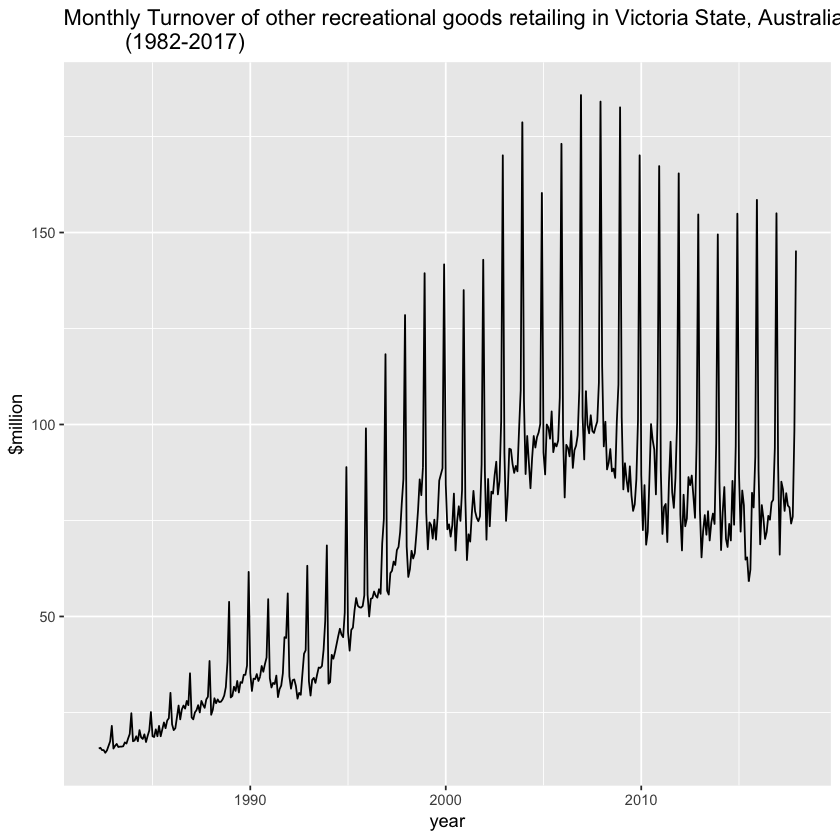

In [23]:
#plot the original series from 1982-2015 with the last two year's worth of observations 2016-2017
#read RetailDataAll to R
mytsAll <- read_xlsx("RetailDataAll.xlsx", skip=3) %>% pull("28397371") %>% 
  ts(start = c(1982,4), frequency = 12)
#plot the time series
autoplot(mytsAll) +
  ggtitle("Monthly Turnover of other recreational goods retailing in Victoria State, Australia
          (1982-2017)")+
  xlab("year")+
  ylab("$million") 

### Q10 plot the point forecasts you have generated for the 2016-2017 period from alternative methods/models you have studied throughout the semester. These should include forecasts generated from:
* the benchmark method
* an ets model;
* an ARIMA model.

In [25]:
#forecast model: benchmark model seasonal naive
fore_snaive <- snaive(myts, h=12*2, lambda= BoxCox.lambda(myts) )

#forecast model: ETS (M,A,M)
fit_ets <- myts %>% ets(model = "MAM", damped = F) 
fore_ets <- forecast(fit_ets, h = 12*2)

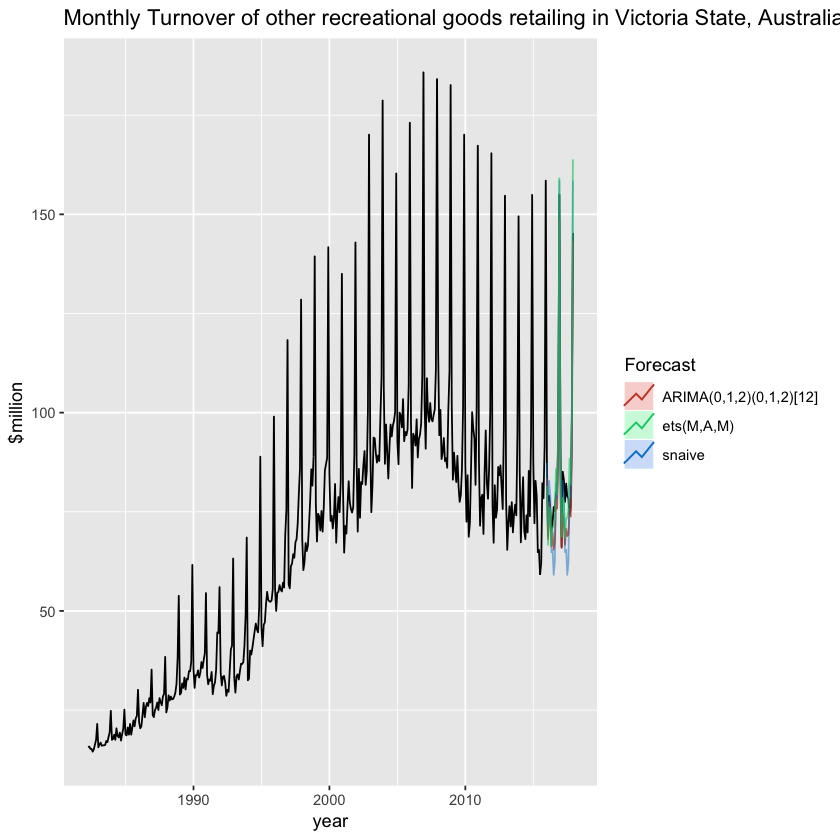

In [26]:
#visualise the forecasts with actual values
autoplot(mytsAll) +
  #autolayer(myts, series="my series") +
  #autolayer(myts.test, series="last two years observations") +
  autolayer(fore_arima, PI=F, series = "ARIMA(0,1,2)(0,1,2)[12]",alpha = 0.8)+
  autolayer(fore_snaive, PI=F, series = "snaive",alpha = 0.5)+
  autolayer(fore_ets, PI=F, series = "ets(M,A,M)",alpha = 0.65)+
  ggtitle("Monthly Turnover of other recreational goods retailing in Victoria State, Australia")+
  xlab("year")+
  ylab("$million") +
  guides(colour=guide_legend(title="Forecast"))

#### SUM
* The increasing/decreasing trend for the given time series changed over the time without a fixed period brings difficulty in predicting the trend. 
* Seasonal Naive performs badly as the prediction values are away from the actual.
* The forecasts from ETS model performs well as seasonal variation and little increasing trend are close to the actual data.

### Q11 Summarise the accuracy of the competing forecasts in an appropriate table by calculating the RMSE, MAPE and MASE over the period 2016-2017 and choose the best model/method from this evaluation. Comment on how different these measures are between the competing models.

In [27]:
#record test error for all models 
tab <- matrix(NA, ncol = 4, nrow=3)
tab[1,] <- accuracy(fore_ets, mytsAll)[2,c(2,3,5,6)]
tab[2,] <- accuracy(fore_arima, mytsAll)[2,c(2,3,5,6)]
tab[3,] <- accuracy(fore_snaive, mytsAll)[2,c(2,3,5,6)]
colnames(tab)<- c("RMSE","MAE","MAPE","MASE")
rownames(tab)<- c("ets(M,A,M)","ARIMA(0,1,2)(0,1,2)[12]", "Snaive")
tab # tabulate predict error for three method/model

,RMSE,MAE,MAPE,MASE
"ets(M,A,M)",6.610448,5.094491,5.898447,0.9268714
"ARIMA(0,1,2)(0,1,2)[12]",7.052675,5.853702,6.968629,1.0649993
Snaive,9.236138,7.262500,8.906865,1.3213104


* The best model is ETS. With lowest test errors, it has little increasing trend and similar seasonal variation to the actual data.  
* ARIMA model comes second as it failed to return an increasing trend. 
* Seasonal Naive perform worst because of higher variations and no trend which are different from the actual observations.


### Q12 Use the top two models, generate and plot forecasts and 80% forecast  intervals for the series for the period 2018-2019.

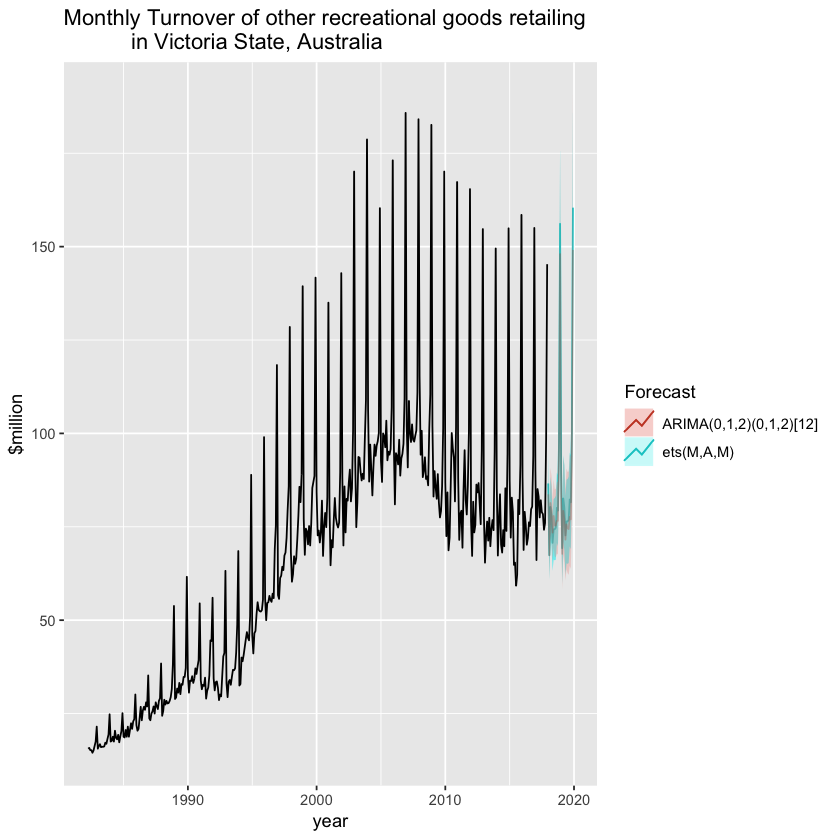

In [28]:
#fit ets model with all data 
fit_ets_all <- mytsAll %>% ets(model = "MAM", damped = F) 
#fitted ets model to do forecasts for 2018-2019
fore_ets_2018_2019 <- forecast(fit_ets_all, h = 12*2,level=80)

#fit arima model with all data 
fit_arima_all <- Arima(mytsAll, lambda = BoxCox.lambda(mytsAll), order = c(0,1,2), seasonal = c(0,1,2))
#fitted arima model to do forecasts for 2018-2019
fore_arima_2018_2019 <- forecast(fit_arima_all, h = 12*2,level=80)

#plot forecasts with original time series
autoplot(mytsAll)+
  autolayer(fore_ets_2018_2019, series = "ets(M,A,M)", alpha = 1)+
  autolayer(fore_arima_2018_2019, series = "ARIMA(0,1,2)(0,1,2)[12]", alpha = 0.3)+
  ggtitle("Monthly Turnover of other recreational goods retailing 
           in Victoria State, Australia")+
  xlab("year")+
  ylab("$million")+
  guides(colour=guide_legend(title="Forecast"))


* ETS model returns forecasts with variation and increasing trend close to observations over the last years. A narrower prediction interval indicates that ETS model is better fitted and has lower uncertainty in prediction. 
* ARIMA model, on the other hand, returns forecasts that has smaller variation and decreasing trend different from the past observations.

## End